In [288]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [289]:
df = pd.read_csv('../../data/process_v1/process_data_6.csv')
df = df[df['city'] == 0]

In [290]:
df['is_street_house'] = (df['accessibility'] == 2).astype(np.int32)

In [291]:
df['landSize_ratio'] = df['landSize'] / df['acreage']

In [292]:
mean_land_size_df = df.groupby('administrative_genre')['landSize'].mean().reset_index().rename(columns = {'landSize': 'meanLandSize'})

df = df.merge(mean_land_size_df, how='left', on = 'administrative_genre')

df['landSize_ratio_with_administrative_genre'] = df['landSize'] / df['meanLandSize']
df['acreage_ratio_with_meanLandSize'] = df['acreage'] / df['meanLandSize']


In [293]:
{'fitThreeCars': 0,
 'fitOneCarAndOneMotorbike': 1,
 'notInTheAlley': 2,
 'parkCar': 3,
 'theBottleNeckPoint': 4,
 'fitTwoCars': 5,
 'narrorRoad': 6}

{'fitThreeCars': 0,
 'fitOneCarAndOneMotorbike': 1,
 'notInTheAlley': 2,
 'parkCar': 3,
 'theBottleNeckPoint': 4,
 'fitTwoCars': 5,
 'narrorRoad': 6}

In [294]:
cat_cols = ['is_street_house', 'ward', 'street', 'district', 'typeOfRealEstate', 'houseDirection', 'accessibility', 'certificateOfLandUseRight'] + [c for c in df.columns.tolist() if '_lat' in c or '_lon' in c]
target_cols = ['target']
remove_cols = ['price', 'description', 'city'] + [c for c in df.columns if 'distance_hcm' in c]
num_cols = [c for c in df.columns.tolist() if c not in (cat_cols + target_cols + remove_cols)]

cat_cols = list(set(cat_cols))
target_cols = list(set(target_cols))
remove_cols = list(set(remove_cols))
num_cols = list(set(num_cols))

print(len(cat_cols), len(target_cols), len(remove_cols), len(num_cols))

28 1 55 154


In [295]:
cat_cols

['nearest_4_lon',
 'nearest_2_lat',
 'accessibility',
 'nearest_6_lat',
 'district_lat',
 'nearest_1_lon',
 'street',
 'nearest_3_lon',
 'certificateOfLandUseRight',
 'nearest_8_lon',
 'nearest_5_lat',
 'district_lon',
 'houseDirection',
 'nearest_0_lat',
 'nearest_0_lon',
 'is_street_house',
 'nearest_5_lon',
 'nearest_1_lat',
 'nearest_6_lon',
 'nearest_3_lat',
 'ward',
 'nearest_7_lat',
 'typeOfRealEstate',
 'nearest_7_lon',
 'nearest_8_lat',
 'nearest_4_lat',
 'nearest_2_lon',
 'district']

In [296]:
num_cols

['distance_hn_Hồ Ngọc Khánh',
 'num_of_fast_food_in_2000m_radius',
 'num_of_marketplace_in_1000m_radius',
 'nearest_0_district',
 'num_of_school_in_2000m_radius',
 'num_of_atm_in_500m_radius',
 'distance_hn_Aeon Mall Long Biên',
 'num_of_police_in_2000m_radius',
 'distance_hn_Lotte Center Hanoi',
 'nearest_6_district',
 'nearest_5_ward',
 'num_of_place_of_worship_in_2000m_radius',
 'nearest_2_district',
 'distance_hn_Hồ Tây 3',
 'num_of_place_of_worship_in_1000m_radius',
 'nearest_4_street',
 'num_of_university_in_500m_radius',
 'nearest_3_district',
 'acreage_ratio_with_meanLandSize',
 'acreage',
 'distance_hn_Hồ Gươm',
 'distance_hn_Hàng Hành',
 'num_of_cafe_in_500m_radius',
 'num_of_place_of_worship_in_500m_radius',
 'distance_hn_Trung tâm thương mại Hà Nội Keangnam',
 'num_of_restaurant_in_500m_radius',
 'num_of_kindergarten_in_1000m_radius',
 'density',
 'distance_hn_Công viên nước Hồ Tây',
 'nearest_3_street',
 'nearest_5_district',
 'num_of_bank_in_2000m_radius',
 'num_of_univer

In [297]:
print(len(num_cols))

154


In [298]:
train_independent_corr = df[num_cols].corr()
train_seleted_corr_columns = np.full((train_independent_corr.shape[0],), True, dtype=bool)
for i in range(train_independent_corr.shape[0]):
    for j in range(i + 1, train_independent_corr.shape[0]):
        if train_independent_corr.iloc[i, j] >= 0.99:

            if train_seleted_corr_columns[j]:
                train_seleted_corr_columns[j] = False
train_selected_columns = df[num_cols].columns[train_seleted_corr_columns]
print(train_selected_columns.shape)

(136,)


In [299]:
# train_selected_columns = list(train_selected_columns)
train_selected_columns = num_cols

In [300]:
df[cat_cols] = df[cat_cols].fillna(100)
df[cat_cols] = df[cat_cols].astype(np.int32)

In [301]:
df = df[cat_cols + num_cols + target_cols]

In [302]:
df = df[df[target_cols[0]] != np.inf]
df = df[df[target_cols[0]] != -np.inf]

In [303]:
df = df[df[target_cols[0]] >= 10]
df = df[df[target_cols[0]] < 100 * 10]

In [304]:
categorical_features_indices = [i for i, c in enumerate(df.columns.tolist()) if c in cat_cols]

In [305]:
X = df.drop(target_cols[0], axis=1)
y = df[target_cols[0]] / 100

In [306]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(98580, 182) (98580,)
(10954, 182) (10954,)


In [307]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [308]:
model = CatBoostRegressor(verbose=100, iterations = 5000, task_type='GPU', devices = '0:1')
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',
    # plot=True
)

Learning rate set to 0.064452
0:	learn: 1.2229046	test: 1.2108992	best: 1.2108992 (0)	total: 23.9ms	remaining: 1m 59s
100:	learn: 0.5880558	test: 0.5806683	best: 0.5806683 (100)	total: 2.18s	remaining: 1m 45s
200:	learn: 0.5637385	test: 0.5627739	best: 0.5627739 (200)	total: 4.35s	remaining: 1m 43s
300:	learn: 0.5493954	test: 0.5536269	best: 0.5536269 (300)	total: 6.51s	remaining: 1m 41s
400:	learn: 0.5393055	test: 0.5478155	best: 0.5478155 (400)	total: 8.68s	remaining: 1m 39s
500:	learn: 0.5310428	test: 0.5439246	best: 0.5439246 (500)	total: 10.9s	remaining: 1m 37s
600:	learn: 0.5231252	test: 0.5403439	best: 0.5403439 (600)	total: 13s	remaining: 1m 35s
700:	learn: 0.5164229	test: 0.5373300	best: 0.5373300 (700)	total: 15.2s	remaining: 1m 33s
800:	learn: 0.5105406	test: 0.5353051	best: 0.5353051 (800)	total: 17.4s	remaining: 1m 31s
900:	learn: 0.5051319	test: 0.5327380	best: 0.5327380 (900)	total: 19.6s	remaining: 1m 29s
1000:	learn: 0.5004817	test: 0.5309163	best: 0.5309142 (999)	tota

In [309]:
feature_importances = pd.DataFrame(model.get_feature_importance(),columns=['importance'])
feature = pd.DataFrame(df.columns,columns=['feature'])
feature_importance_df = pd.concat([feature_importances,feature],axis=1)
feature_importance_df[feature_importance_df['importance'] == 0]

,importance,feature
0,0.0,nearest_4_lon
5,0.0,nearest_1_lon
9,0.0,nearest_8_lon
11,0.0,district_lon
13,0.0,nearest_0_lat
14,0.0,nearest_0_lon
16,0.0,nearest_5_lon
18,0.0,nearest_6_lon
23,0.0,nearest_7_lon
26,0.0,nearest_2_lon


Text(0.5, 1.0, 'Feature Importances ')

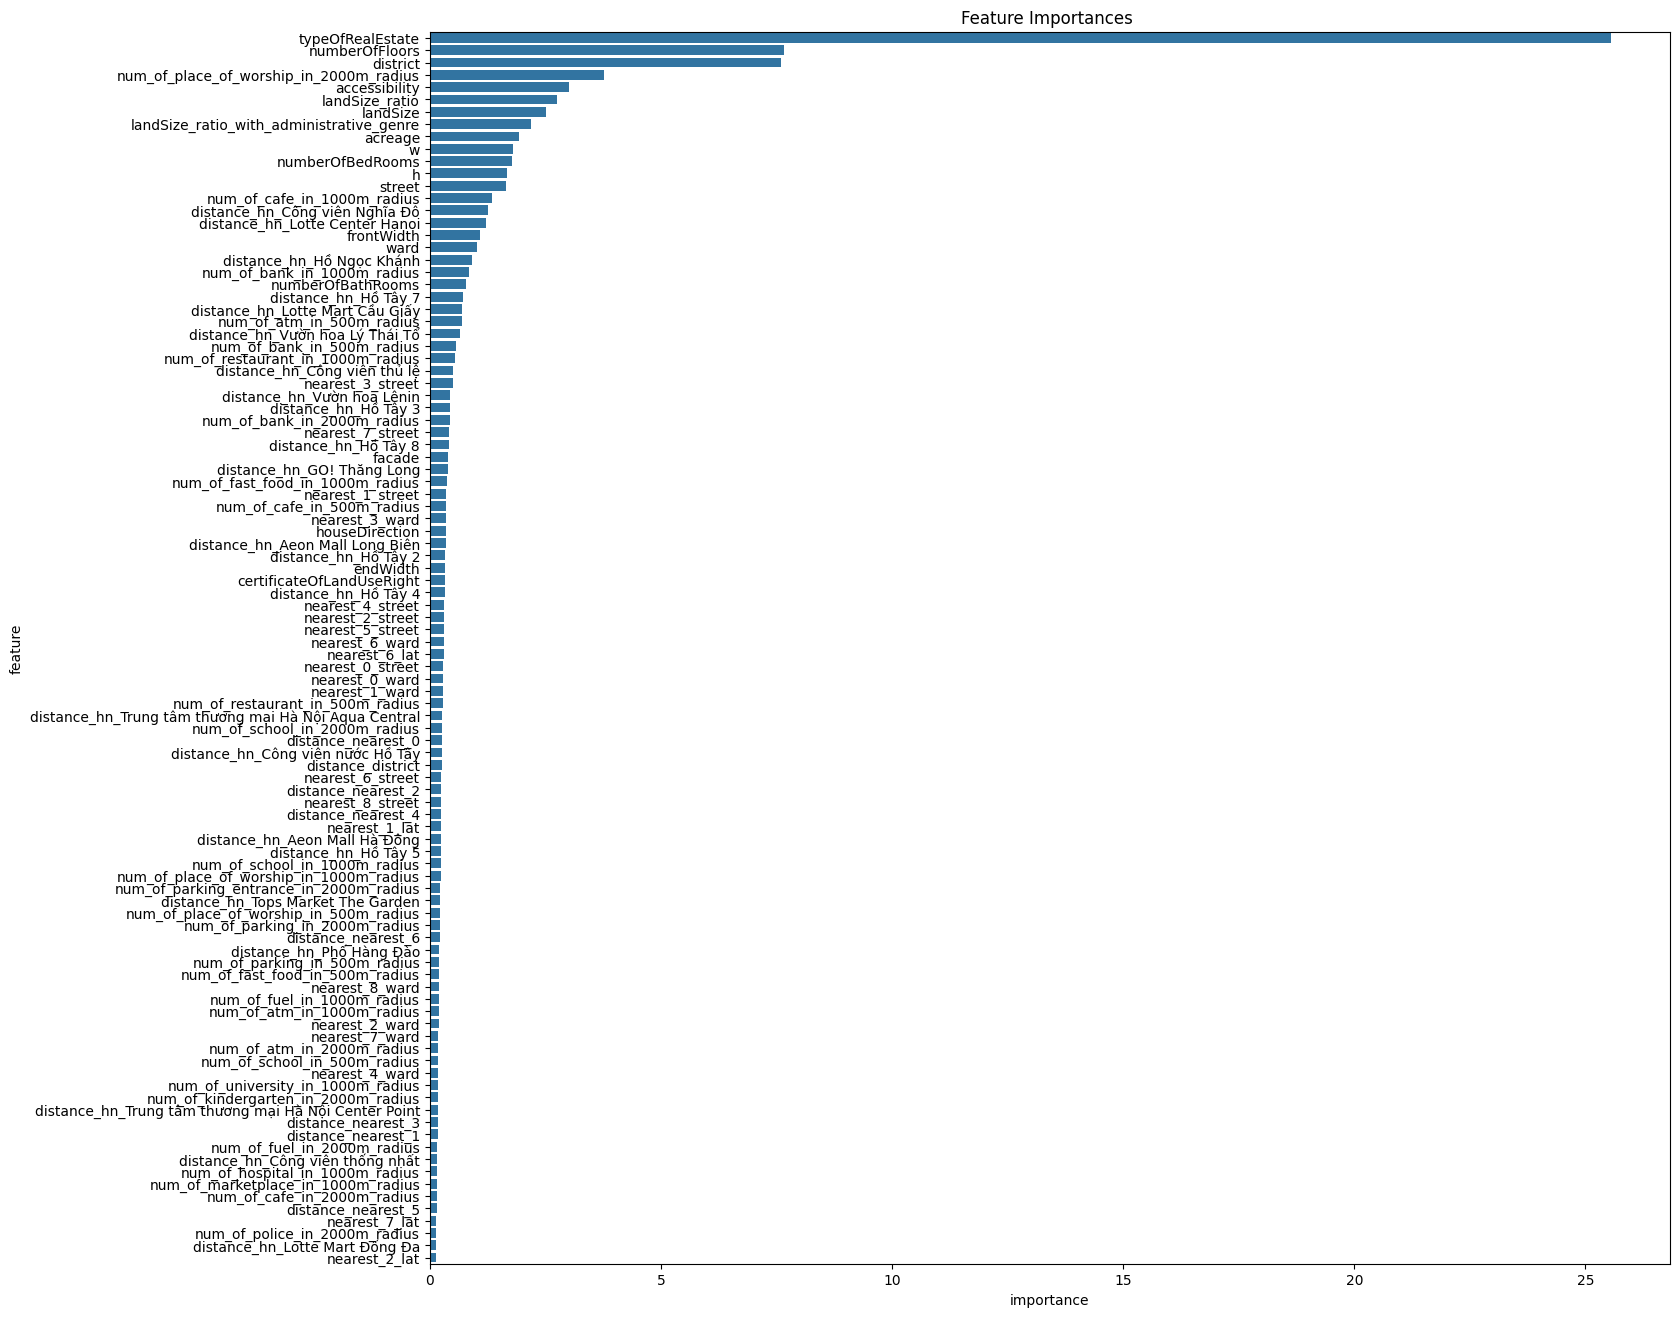

In [310]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_df.sort_values(by='importance', ascending=False).head(100), x='importance', y='feature')
plt.title('Feature Importances ')

In [311]:
model.predict(X_validation)

array([3.61678933, 0.79777438, 3.71081223, ..., 0.68335557, 0.53188125,
       1.97810041])

In [312]:
df.groupby(['administrative_genre'])["target"].mean()

administrative_genre
0     71.949487
1    164.396368
Name: target, dtype: float64